# Approximating sin(x) for integers

Assumptions:

* Care about $\sin(x) \in \left[0, \frac{\pi}{2}\right]$

In [86]:
%matplotlib inline
import sympy as sym
sym.init_printing()
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable
import math
import functools
import operator
plt.rcParams['figure.figsize'] = [6, 3]
plt.rcParams['figure.dpi'] = 100

def intify(x):
    return np.floor(x)

In [2]:
space = np.linspace(0, np.pi / 2, 1000)
ideal_sine = np.sin(space)

## Approximate Using Taylor Series

To do this, consider the Taylor series:

\begin{equation}
\sin(x) = \sum_{n = 0}^{\infty} \frac{f^{(n)}(a)}{n!} (x - a)^n
\end{equation}

Let:

\begin{equation}
\sin_N(x, a) = \sum_{n = 0}^{N} \frac{f^{(n)}(a)}{n!} (x - a)^n
\end{equation}

Let us find an $a$ and an $N$ such that the maximum error is acceptable. Define the error:

\begin{equation}
\varepsilon_N = max(\sin_N(x, a) - \sin(x)) \forall x \forall a \in \left[0, \frac{\pi}{2} \right]
\end{equation}

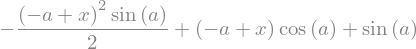

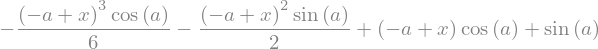

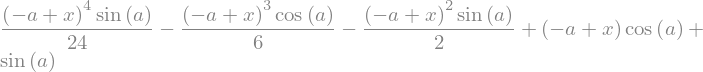

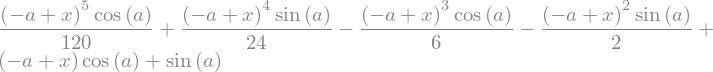

In [3]:
x, a = sym.symbols('x, a', real=True, positive=True)
def sin_tailor(n: int) -> Callable[[float, float], float]:
    def of_order(order: int):
        # Calculate derivatives
        deriv = sym.sin(a)
        for i in range(0, order):
            deriv = sym.diff(deriv, a)
        return deriv / sym.factorial(order) * (x - a)**order
    return functools.reduce(operator.add, (of_order(i) for i in range(1, n + 1)), of_order(0))

tailor_approximations = [
    sin_tailor(n)
    for n in range(0, 5 + 1)
]

for approx in tailor_approximations:
    display(approx)

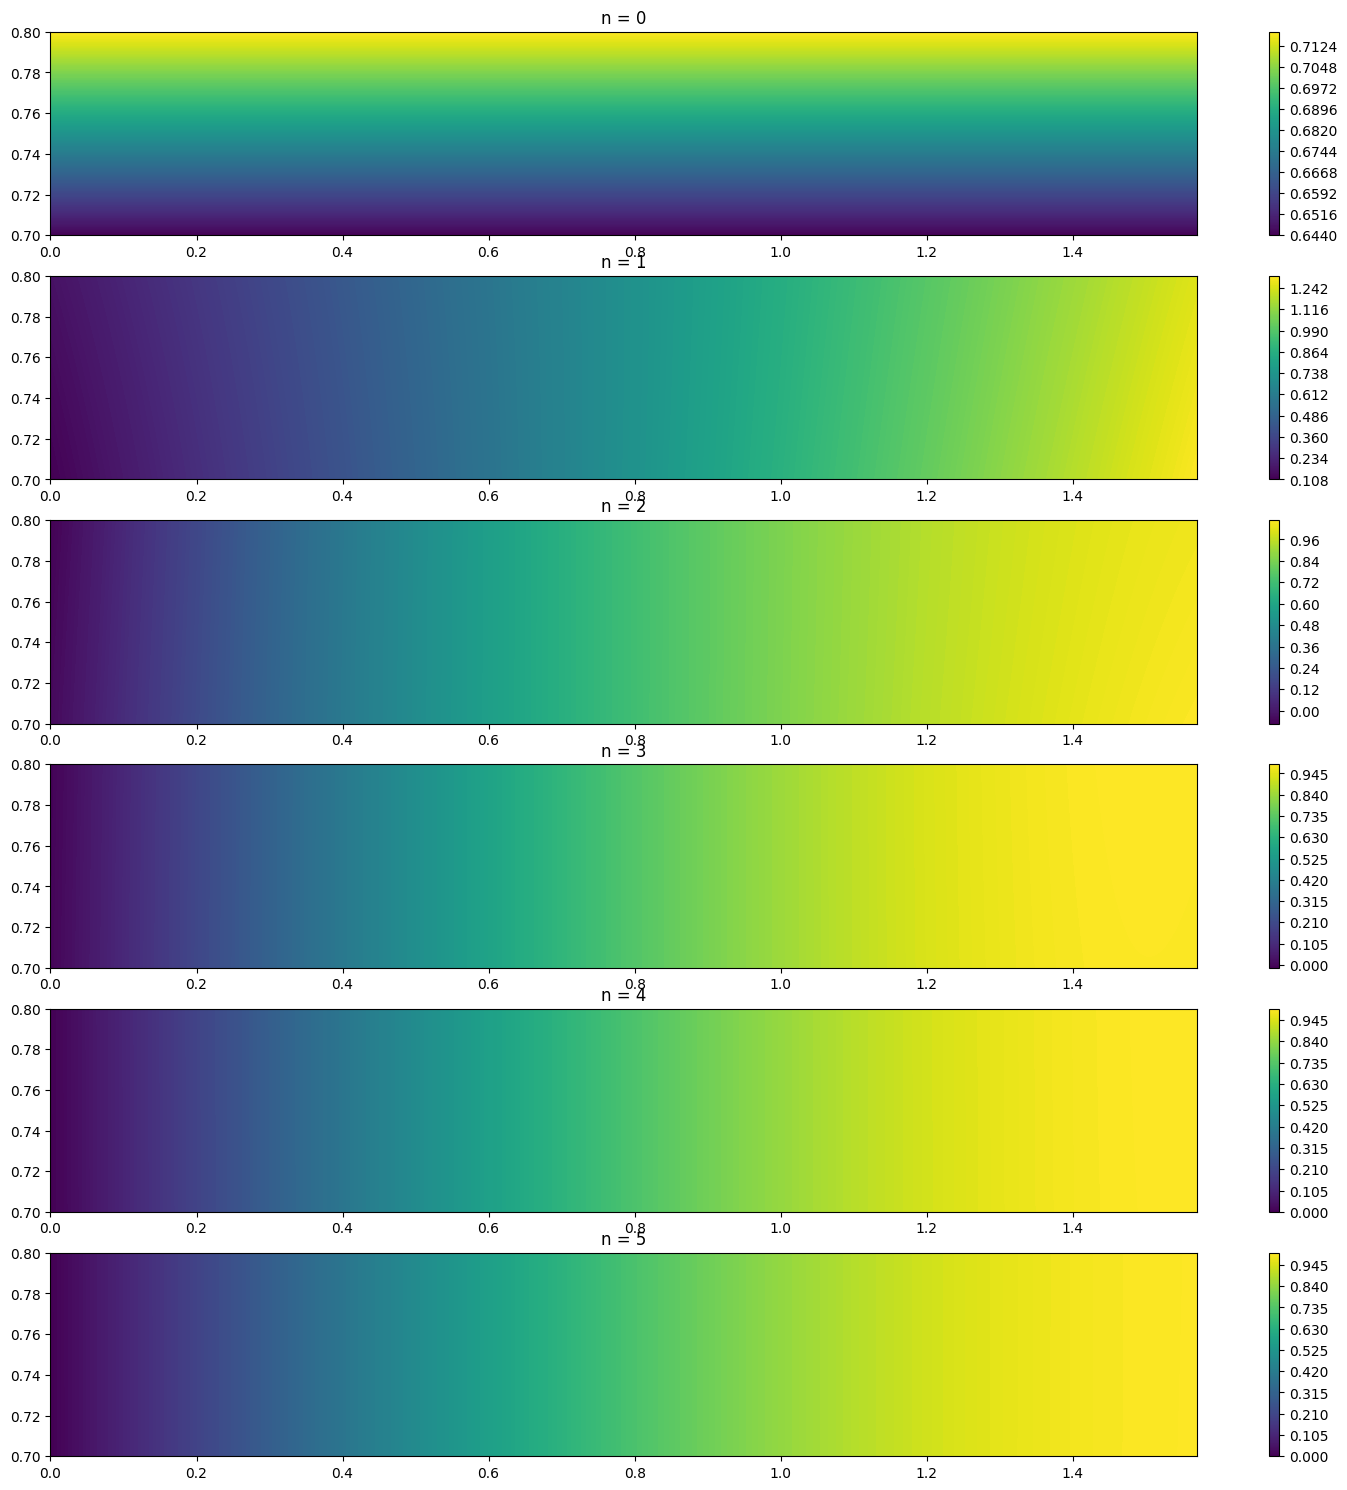

In [29]:
# Visualize errors now that we have derived the lambdas
# The linspace range for the adomain is a bit of the classical manual optimization
xdomain, adomain = np.meshgrid(space, np.linspace(0.7, 0.8, 1000))

fig, axs = plt.subplots(6,1)
fig.set_size_inches(18.5, 18.5)
for n in range(0, 5 + 1):
    f = sym.lambdify((x, a), tailor_approximations[n])(xdomain, adomain)
    contour_p = axs[n].contourf(xdomain, adomain, f, levels=200)
    axs[n].set_title(f'n = {n}')
    fig.colorbar(contour_p)

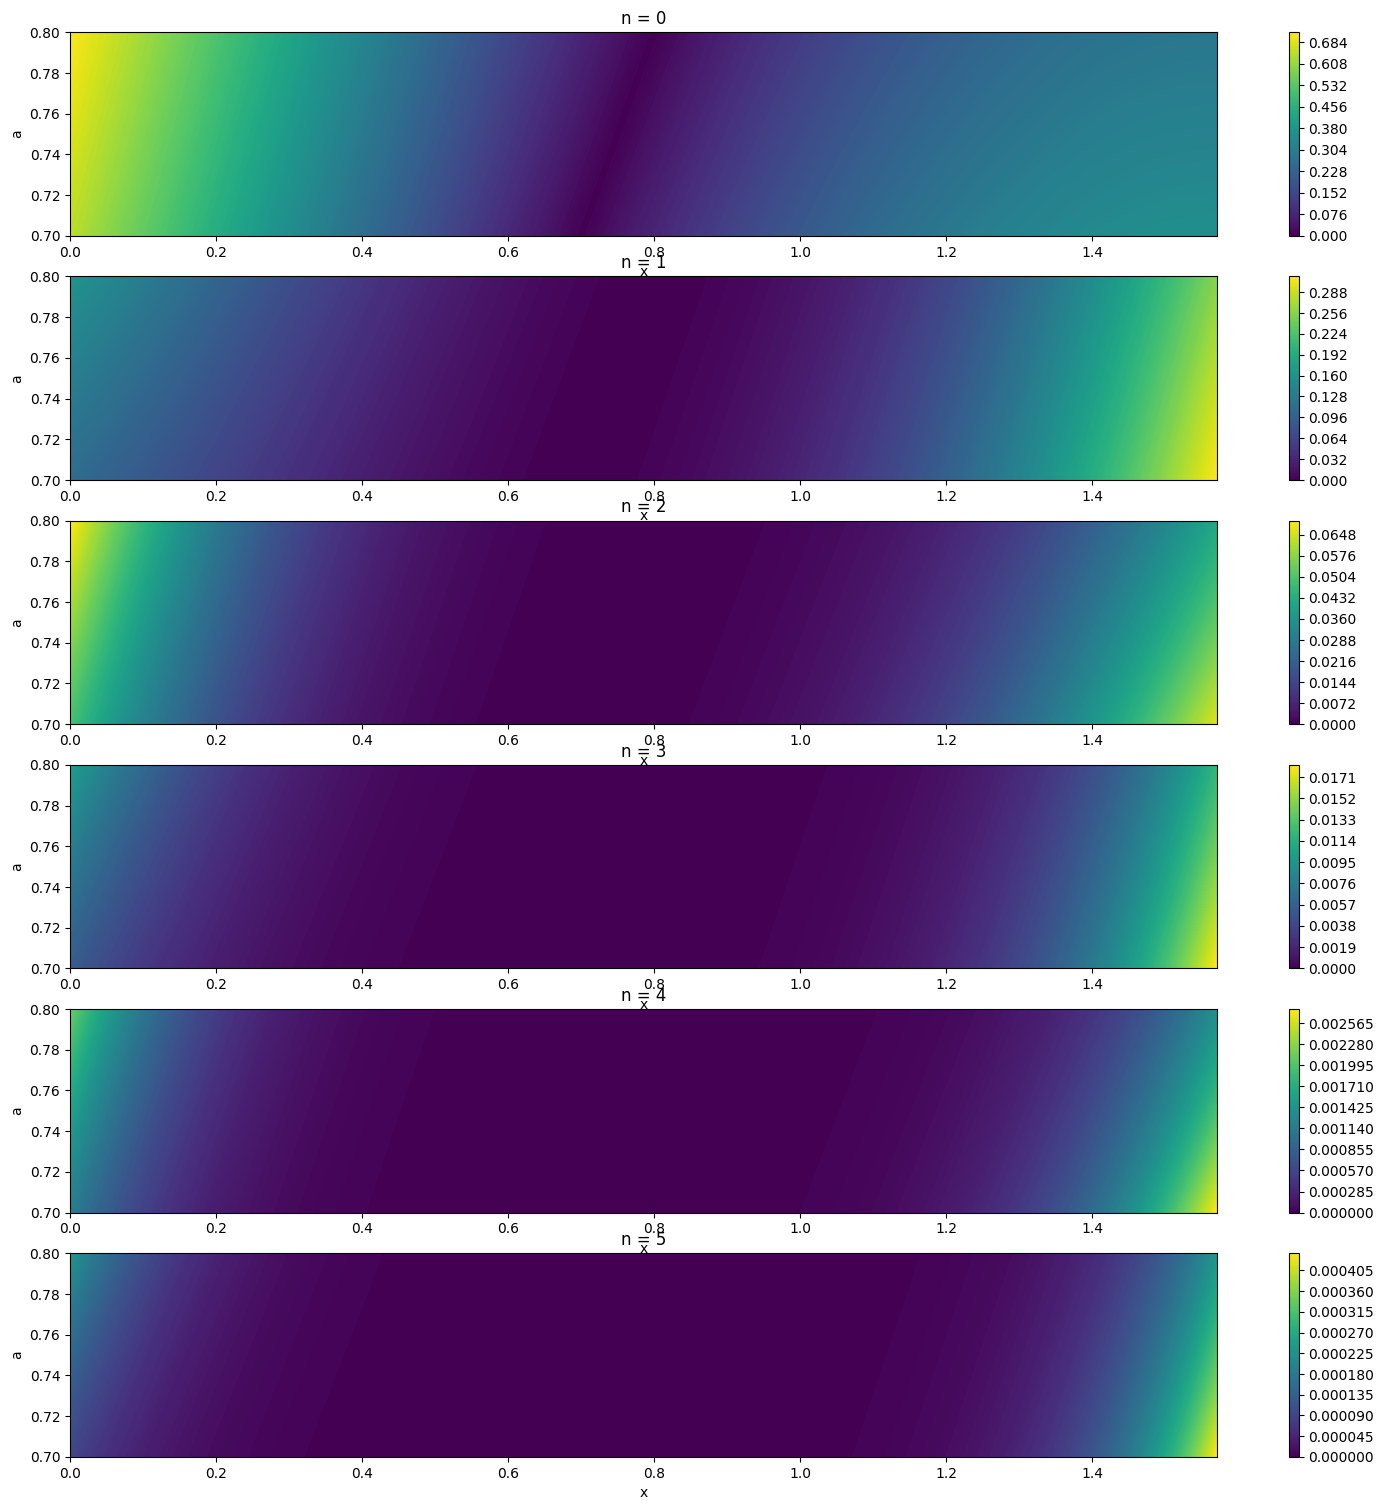

In [30]:
# Calculate Errors and plot errors

fig, axs = plt.subplots(6,1)
fig.set_size_inches(18.5, 18.5)
zed_values = []
for n in range(0, 5 + 1):
    zed_values.append(
        np.sqrt((np.sin(xdomain) - sym.lambdify((x, a), tailor_approximations[n])(xdomain, adomain))**2)
    )
    contour_p = axs[n].contourf(xdomain, adomain, zed_values[n], levels=200)
    axs[n].set_title(f'n = {n}')
    axs[n].set_xlabel('x')
    axs[n].set_ylabel('a')
    fig.colorbar(contour_p)

In [33]:
# Pretty cool plots, but we have a job to do -- we gotta pick a value of a that yields the best RMSE.
optimal_as = []
for i, zed_value in enumerate(zed_values):
    minimized = np.inf
    minimized_a = np.inf
    for aval, zed in zip(space, zed_value.transpose()):
        candidate = np.sqrt(np.sum(zed**2))
        if candidate < minimized:
            minimized_a = aval
            minimized = candidate
    optimal_as.append(minimized_a)
    print(f'Minimal a for n={i}: {minimized_a}')

Minimal a for n=0: 0.7500198677489145
Minimal a for n=1: 0.7500198677489145
Minimal a for n=2: 0.7500198677489145
Minimal a for n=3: 0.7500198677489145
Minimal a for n=4: 0.7500198677489145
Minimal a for n=5: 0.7500198677489145


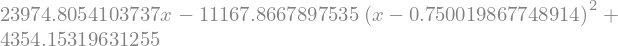

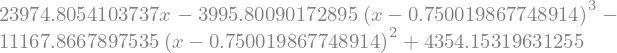

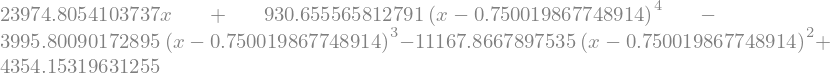

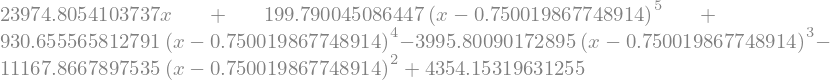

In [92]:
# Substitue into our tailor expressions
optimal_taylor_approximations = [
    (2**15 - 1) * approx.subs(a, opt_a)
    for approx, opt_a in zip(tailor_approximations, optimal_as)
]
for app in optimal_taylor_approximations:
    display(app)

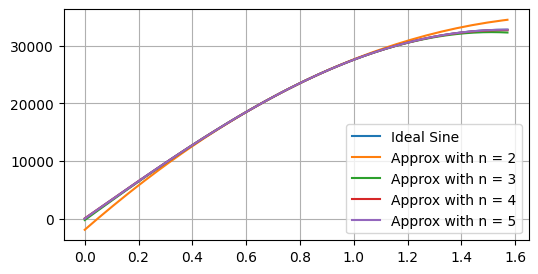

In [93]:
fig = plt.figure()
ax = plt.axes()
ax.plot(space, (2**15 - 1) * ideal_sine, label='Ideal Sine')
def approximation(n):
    return np.vectorize(sym.lambdify(x, optimal_taylor_approximations[n]))
for n in range(2, 5 + 1):
    ax.plot(space, np.floor(approximation(n)(space)), label=f'Approx with n = {n}')
ax.grid()
ax.legend()

/tmp/ipykernel_27195/664484289.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(space, 100 * (approximation(n)(space) - (2**15 - 1) * ideal_sine) / ((2**15 - 1) * ideal_sine), label=f'Error for n = {n}')


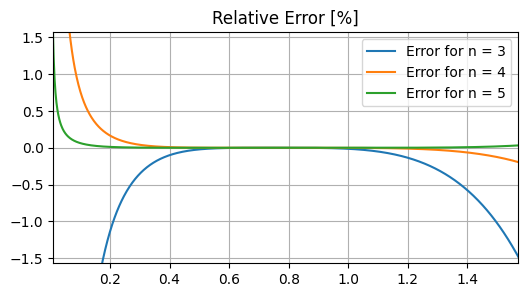

In [84]:
fig = plt.figure()
ax = plt.axes()
for n in range(3, 5 + 1):
    ax.plot(space, 100 * (approximation(n)(space) - (2**15 - 1) * ideal_sine) / ((2**15 - 1) * ideal_sine), label=f'Error for n = {n}')
ax.grid()
ax.set_title('Relative Error [%]')
ax.set_xlim((0.01, np.pi / 2))
ax.set_ylim((-np.pi / 2, np.pi / 2))
ax.legend()

Looks like $n = 4$ is good enough.

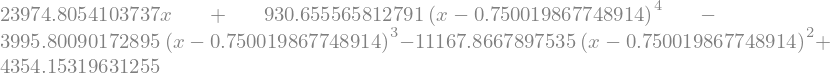

In [77]:
display((2**15 - 1) * optimal_taylor_approximations[4])